In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_stochastic_vibration_psd(pow:float=1e-8):
    """
    Generate a stochastic PSD with flat baseline, 5 Hz peak, and random high-freq peaks.
    
    Parameters
    ----------
    n_freq : int
        Number of frequency points
    freq_min : float
        Minimum frequency in Hz
    freq_max : float
        Maximum frequency in Hz
    
    Returns
    -------
    freqs : ndarray
        Frequency array in Hz
    psd : ndarray
        PSD values in arcsec^2/Hz
    """
    # Create logarithmically-spaced frequency grid
    freqs = np.logspace(-2,4,1000)
    
    # Initialize PSD with flat baseline
    psd_baseline = 100  
    psd = psd_baseline * np.ones_like(freqs)
    
    # 1. Add sharp peak at 5 Hz (Lorentzian)
    f_peak = 5.0
    width = 0.5  # Hz
    psd_peak_amp = 800  
    lorentzian_peak = psd_peak_amp * (width / 2)**2 / ((freqs - f_peak)**2 + (width / 2)**2)
    psd += lorentzian_peak
    
    freq_cutoff = 8.0

    psd[freqs>freq_cutoff] *= (freq_cutoff/freqs[freqs>freq_cutoff])**3

    # freq_max_peaks = 2e3

    # # Create many small Lorentzian peaks between just above the main 5 Hz peak
    # n_peaks = 8
    # peak_freqs = np.logspace(np.log10(f_peak * 1.2), np.log10(freq_max_peaks), n_peaks)
    # for fp in peak_freqs:
    #     amp = psd_baseline * (0.8 * (f_peak / fp)**0.2 + 0.2)
    #     lor = amp * (width / 2.0)**2 / ((freqs - float(fp))**2 + (width / 2.0)**2)
    #     psd += lor
    
    # Enforce integral
    psd *= pow/np.trapezoid(psd,freqs)

    return freqs, psd

In [3]:
def generate_timeseries(freqs, psd, N, dt, seed:int=42):
    df = 1.0 / (N * dt)
    pos_freqs = np.arange(0, N//2 + 1) * df

    S_pos = np.interp(pos_freqs, freqs, psd, left=psd[0], right=psd[-1])

    # Build complex spectrum consistent with one-sided PSD S_pos
    rng = np.random.default_rng(seed)
    spec = np.zeros(N, dtype=complex)

    # DC component (real)
    spec[0] = rng.normal(loc=0.0, scale=np.sqrt(S_pos[0] * N * df))
    # positive freqs 1..N/2-1
    for k in range(1, N//2):
        Sfk = S_pos[k]
        amp = np.sqrt(0.5 * Sfk * N * df)
        phi = rng.uniform(0, 2 * np.pi)
        spec[k] = amp * (np.cos(phi) + 1j * np.sin(phi))
        spec[-k] = np.conj(spec[k])
    # Nyquist (if even N) should be real
    if N % 2 == 0:
        k = N//2
        spec[k] = rng.normal(loc=0.0, scale=np.sqrt(S_pos[k] * N * df))

    # inverse FFT -> time series (real)
    timeseries = np.fft.ifft(spec).real
    
    return timeseries

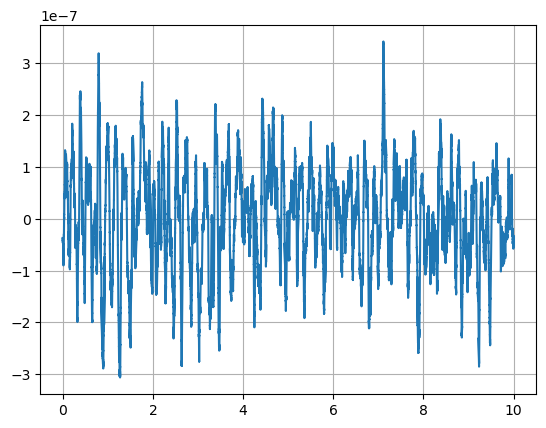

In [4]:
freqs, psd = generate_stochastic_vibration_psd()

N = int(1e+6)
dt = 1e-5
tvec = np.arange(N)*dt
timeseries = generate_timeseries(freqs, psd, N=N, dt=dt)

plt.figure()
plt.plot(tvec,timeseries)
plt.grid()

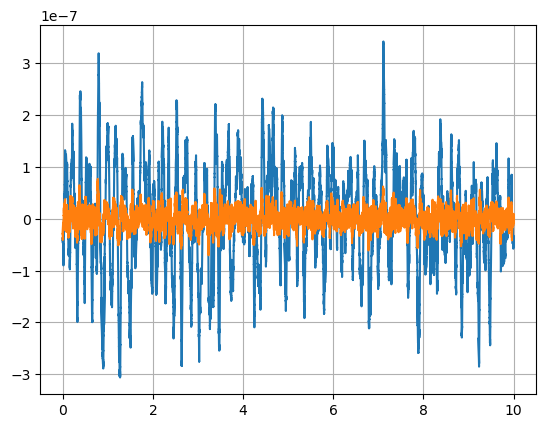

In [5]:
# Simple integrator controller
gain = 0.4
cmd = 0
delay = 2
leak = 0.7

f1 = 1000
dt1 = 1/f1
out1 = np.zeros(N)

for i in range(N):
    out1[i] = timeseries[i]-cmd
    if i > delay and i % int(dt1/dt) == 0:
        cmd += gain*timeseries[i-delay]
        cmd *= leak

plt.figure()
plt.plot(tvec,timeseries)
plt.plot(tvec,out1)
plt.grid()

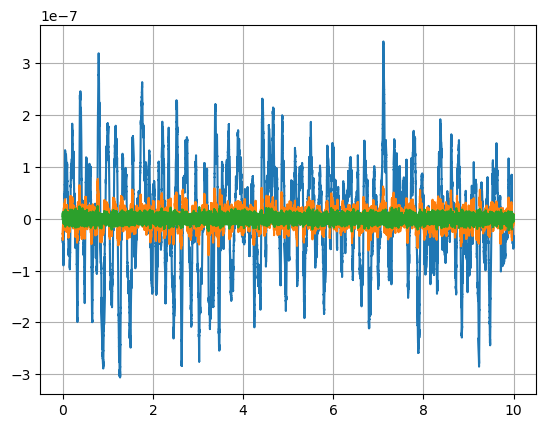

In [6]:
f2 = 2000
dt2 = 1/f2
out2 = np.zeros(N)

for i in range(N):
    out2[i] = out1[i]-cmd
    if i > delay and i % int(dt2/dt) == 0:
        cmd += gain*out1[i-delay]
        cmd *= leak

plt.figure()
plt.plot(tvec,timeseries)
plt.plot(tvec,out1)
plt.plot(tvec,out2)
plt.grid()

Text(0.5, 1.0, 'PSD Comparison: Mutiple frequencies')

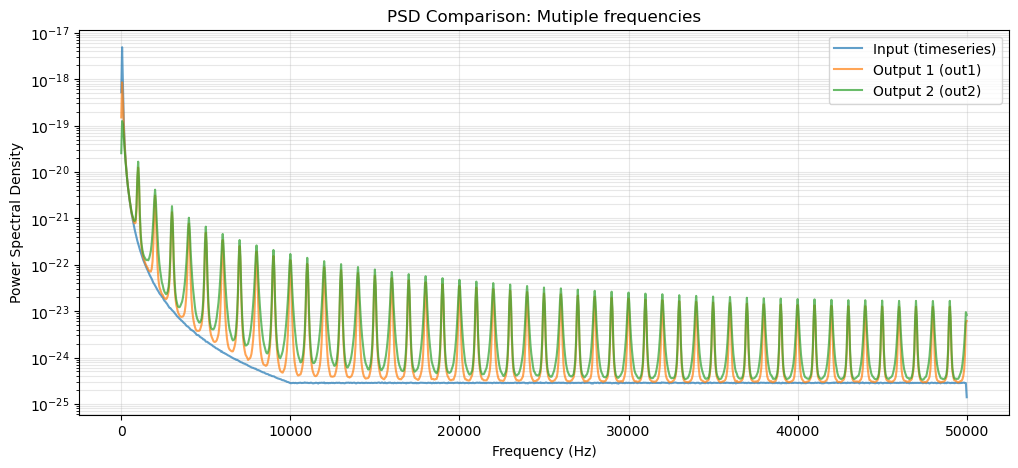

In [10]:
# Compute and plot PSDs for timeseries, out1, out2
from scipy import signal

# Use Welch's method for more stable PSD estimates
f_welch, psd0 = signal.welch(timeseries, fs=1/dt, nperseg=2000)
f_welch, psd1 = signal.welch(out1, fs=1/dt, nperseg=2000)
f_welch, psd2 = signal.welch(out2, fs=1/dt, nperseg=2000)

# Plot PSDs
plt.figure(figsize=(12, 5))
plt.semilogy(f_welch, psd0, label='Input (timeseries)', alpha=0.7)
plt.semilogy(f_welch, psd1, label='Output 1 (out1)', alpha=0.7)
plt.semilogy(f_welch, psd2, label='Output 2 (out2)', alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(which='both', alpha=0.3)
plt.title('PSD Comparison: Mutiple frequencies')

# # Zoom in on low frequencies
# plt.figure(figsize=(12, 5))
# mask = f_welch < 100  # Focus on first 100 Hz
# plt.semilogy(f_welch[mask], psd0[mask], label='Input (timeseries)', alpha=0.7)
# plt.semilogy(f_welch[mask], psd1[mask], label='Output 1 (out1)', alpha=0.7)
# plt.semilogy(f_welch[mask], psd2[mask], label='Output 2 (out2)', alpha=0.7)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density')
# plt.legend()
# plt.grid(which='both', alpha=0.3)
# plt.title('PSD Comparison: Low Frequency Detail (< 100 Hz)')

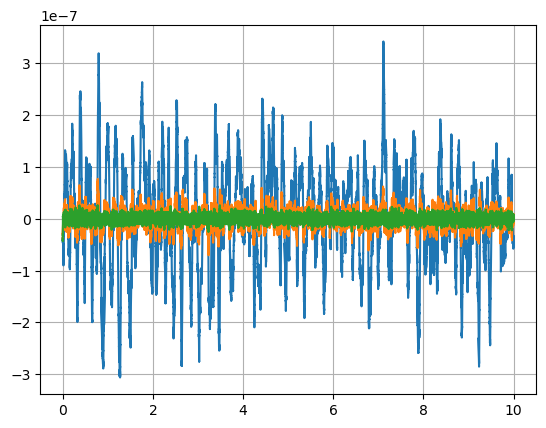

In [11]:
f3 = 1777
dt3 = 1/f3
out3 = np.zeros(N)

for i in range(N):
    out3[i] = out1[i]-cmd
    if i > delay and i % int(dt3/dt) == 0:
        cmd += gain*out1[i-delay]
        cmd *= leak

plt.figure()
plt.plot(tvec,timeseries)
plt.plot(tvec,out1)
plt.plot(tvec,out3)
plt.grid()

Text(0.5, 1.0, 'PSD Comparison: Non-mutiple frequencies')

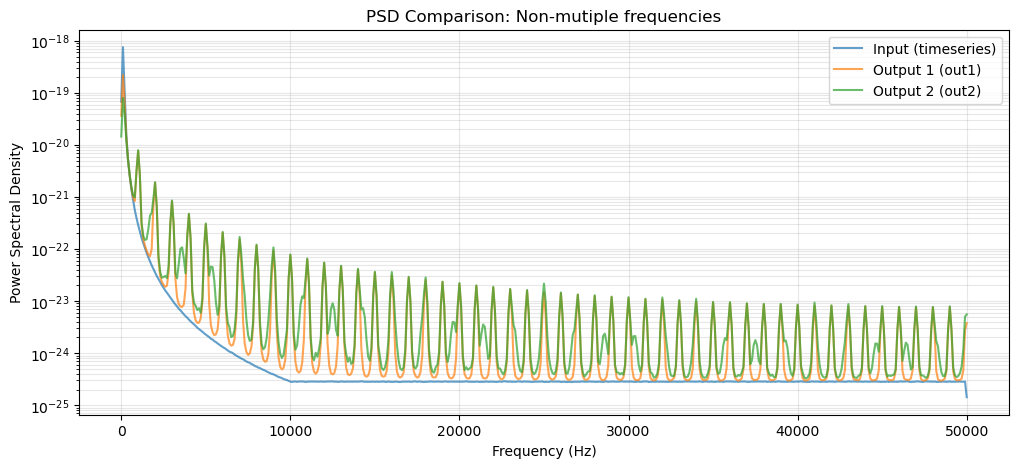

In [14]:

# Use Welch's method for more stable PSD estimates
f_welch, psd0 = signal.welch(timeseries, fs=1/dt, nperseg=1000)
f_welch, psd1 = signal.welch(out1, fs=1/dt, nperseg=1000)
f_welch, psd2 = signal.welch(out3, fs=1/dt, nperseg=1000)

# Plot PSDs
plt.figure(figsize=(12, 5))
plt.semilogy(f_welch, psd0, label='Input (timeseries)', alpha=0.7)
plt.semilogy(f_welch, psd1, label='Output 1 (out1)', alpha=0.7)
plt.semilogy(f_welch, psd2, label='Output 2 (out2)', alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(which='both', alpha=0.3)
plt.title('PSD Comparison: Non-mutiple frequencies')